In [1]:
import importlib
import pyspark.sql.functions as F
from pyspark.sql import Window
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.tsa.ar_model as ar_model
from sklearn.metrics import mean_absolute_error
import pandas as pd
import time
from numpy.fft import fft, ifft

from trade_flow_modelling.src.data_management.data_loader import data_loader
from trade_flow_modelling.src.data_management.data_downloader import data_downloader

import settings
from trade_flow_modelling.src.data_management.sign_extractor import sign_extractor
from modelisation.metrics import metric_calculator
from modelisation.autocorrelation import autocorrelation_calculator
from modelisation.time_series_models import autoregressive_model

# from trade_flow_modelling.src.modelisation.metrics import metric_calculator
# from trade_flow_modelling.src.modelisation.sign_simulator import sign_simulator
# from trade_flow_modelling.src.modelisation.utils import pyspark_utils


%matplotlib inline

DATES TYPES
DATES_UTILS
PYSPARK_UTILS
DATA_LOADER
DATA_DOWNLOADER
SYMBOLS
AUTOCORRELATION_CALCULATOR


In [2]:
importlib.reload(data_downloader)
data_downloader.download_data("BTCUSDT", "daily", "2023-10-01", "2023-11-01")
# data_downloader.download_data("APTUSDT", "monthly", "2022-10", "2022-12")

DATA_DOWNLOADER


<module 'trade_flow_modelling.src.data_management.data_downloader.data_downloader' from '/Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/data_management/data_downloader/data_downloader.py'>

In [3]:
# importlib.reload(data_loader)
data = data_loader.load_data("APTUSDT", "monthly", "2023-11", "2023-11")
# data = data_loader.load_data("BTCUSDT", "monthly", "2023-10", "2023-10")

# print(data.count())
# data.show(10)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=25400Kb max_used=25605Kb free=105671Kb
 bounds [0x000000010a1e0000, 0x000000010bb10000, 0x00000001121e0000]
 total_blobs=9739 nmethods=8778 adapters=874
 compilation: disabled (not enough contiguous free space left)


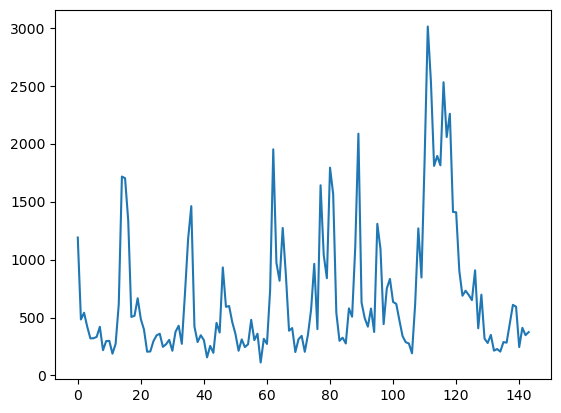

In [ ]:
from trade_flow_modelling.src.modelisation.utils import pyspark_utils

def day_number_as_string(day_number):
    if (day_number >= 1 and day_number <= 9):
        return f"0{day_number}"
    else:
        return f"{day_number}"
    
for i in range(1, 10):
    window = F.window("date_time", "10 minutes").alias("time_window")
    nb_trades_per_bin = data.filter(F.col("date") == f"202311{day_number_as_string(i)}").groupBy(window).agg(F.count("id").alias("nb_trades")).sort("time_window")
    # nb_trades_per_bin.show(100, truncate=False)

    trades = pyspark_utils.get_column_from_pyspark_df(nb_trades_per_bin, column_name="nb_trades", sort_column="time_window")
    # print(len(trades), trades[:10])
    plt.plot(trades, label=f"{day_number_as_string(i)}")
plt.show()

In [ ]:
def percentage_buy_per_day(data):
    cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))
    
    nb_trades_expr = F.count("id").alias("nb_trades")
    pct_buy_expr = F.round(100 * cnt_cond(F.col("side") == "buy") / cnt_cond(F.col("side").isin(["buy", "sell"])), 2).alias("pct_buy")
    pct_buy = data.groupBy(F.col("date")).agg(nb_trades_expr, pct_buy_expr).sort("date")
    return pct_buy

buy_pct = percentage_buy_per_day(data)
buy_pct.show(100)

+--------+---------+-------+
|    date|nb_trades|pct_buy|
+--------+---------+-------+
|20230901|    79529|  50.99|
|20230902|    46090|   51.0|
|20230903|    34732|   50.5|
|20230904|    70789|  52.87|
|20230905|   129532|  50.58|
|20230906|   106644|  49.11|
|20230907|    64638|  51.52|
|20230908|    62435|  48.98|
|20230909|    25500|  47.29|
|20230910|   183349|  47.38|
|20230911|   148667|  48.99|
|20230912|   140802|  51.85|
|20230913|   131254|  51.41|
|20230914|   134383|  51.98|
|20230915|    82808|  49.29|
|20230916|    57493|  48.49|
|20230917|    41993|  50.12|
|20230918|   130244|  48.55|
|20230919|   211645|  21.88|
|20230920|    98759|  45.98|
|20230921|    98554|   44.5|
|20230922|    63414|  49.82|
|20230923|    30406|  46.55|
|20230924|    38377|  48.15|
|20230925|    52018|  48.27|
|20230926|    51826|   48.3|
|20230927|    69839|   48.3|
|20230928|    75243|  49.42|
|20230929|    79328|  46.44|
|20230930|   120229|  49.36|
|20231001|   250790|  48.98|
|20231002|   2

In [2]:
signs = sign_extractor.retrieve_signs("APTUSDT", "2023-11-01", "2023-11-01")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/06 17:32:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [56]:
def plot_autocorrelation(time_series, nb_lags=None, label="Autocorrelation function", log_scale=True):
    fig, axe = plt.subplots(1, 1, figsize=(8, 4))
    autocorrelation = autocorrelation_calculator.calculate_autocorrelation(time_series, nb_lags, "fft")

    axe.plot(autocorrelation, "orange", label=label)
 
    x = [i for i in range(1, len(autocorrelation))]
    y_1 = [l ** (-0.5) for l in range(1, len(autocorrelation) + 1)]
    y_2 = [l ** (-1.9) for l in range(1, len(autocorrelation) + 1)]

    axe.plot(y_1, "grey", linestyle="dashed", label="x^(-0.5)")
    axe.plot(y_2, "brown", linestyle="dashed", label="x^(-1.9)")

    if (log_scale):
        axe.set_yscale("log")

    axe.set_title(f"Autocorrelation plot | {'log' if log_scale else 'linear'} scale")
    axe.set_xlabel("Lag")
    axe.set_ylabel("Autocorrelation")
    axe.set_xlim(-5, nb_lags)
    axe.set_ylim(max(0.001, np.nanmin(autocorrelation) - 0.1), np.nanmax(autocorrelation) + 0.1)
    axe.grid(True)
    axe.legend()
    plt.show()

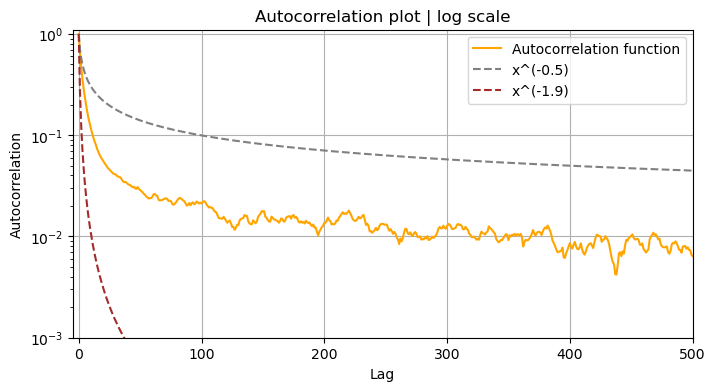

In [60]:
plot_autocorrelation(signs, 500)

In [2]:
signs = sign_extractor.retrieve_signs("APTUSDT", "2023-11-01", "2023-11-03")
# signs = sign_extractor.retrieve_signs("BTCUSDT", "2023-10-14", "2023-10-14")
print(len(signs))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/14 11:51:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


CodeCache: size=131072Kb used=23366Kb max_used=23378Kb free=107705Kb
 bounds [0x00000001069e0000, 0x00000001080e0000, 0x000000010e9e0000]
 total_blobs=9508 nmethods=8548 adapters=872
 compilation: disabled (not enough contiguous free space left)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


223423


In [40]:
# Improve ar_select_order_opti

from modelisation.time_series_models import autoregressive_model
importlib.reload(autoregressive_model)
import bis
importlib.reload(bis)
from modelisation.regression import linear_models
importlib.reload(linear_models)

signs = sign_extractor.retrieve_signs("BTCUSDT", f"2023-10-14", f"2023-10-14")
ar_model = autoregressive_model.AutoregressiveModel(signs[:150000], nb_lags=None)

s = time.time()
nb_lags, times_opti = ar_model.select_model_nb_lags("opti")
e = time.time()
print(f"Nb lags selected: {nb_lags} in {round(e - s, 2)} s ({len(signs)} signs)")
print(f"(total loops: {sum(times_opti[0])} | fit(): {sum(times_opti[1])} | selection(): {sum(times_opti[2])} | OLS(): {sum(times_opti[3])} | s: {sum(times_opti[4])} | dot: {sum(times_opti[5])})")
print(f"{sum(times_opti[0])} | {sum(times_opti[1]) + sum(times_opti[2]) + sum(times_opti[3])}")
# plt.plot(times_opti[0], color="orange", label="opti")
# plt.plot(times_opti[1], color="grey", linestyle="--", label="opti (only fit)")

# plt.legend()
# plt.show()

Max lag has been set to 75 (opti)
Nb lags selected: 57 in 64.53 s (517837 signs)
(total loops: 64.33237957954407 | fit(): 63.73941445350647 | selection(): 0.00639033317565918 | OLS(): 0.00330352783203125 | s: 0.057396888732910156 | dot: 1.0774242877960205)
64.33237957954407 | 63.74910831451416


In [27]:
from statsmodels.tsa.tsatools import lagmat
import statsmodels.api as sm

max_lag = 3

date = f"2023-11-02"
y = sign_extractor.retrieve_signs("APTUSDT", date, date)[:10]
print(f"{date} ({len(y)})")
x, y = lagmat(y, max_lag, original="sep")
x = sm.add_constant(x)
y = y[max_lag:]
x = x[max_lag:]

x_pd = pd.DataFrame(x)
x_selection = x_pd.values[:, slice(max_lag + 1)]
print(x_selection)
print(x_selection.shape)
ols_model = linear_models.OLS(y, x_selection)
ols_model.df_model = x_selection.shape[1] - 1
ols_model.k_constant = 1
res = ols_model.fit()


print(len(res.beta), res.beta)


2023-11-02 (10)
[[ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]
(7, 2)
2 [0.08333333 0.41666667]


In [15]:
from scipy.linalg._decomp import _asarray_validated
from scipy.linalg import _decomp_svd
from numpy.linalg import svd

def pinv_scipy(a, atol=None, rtol=None, return_rank=False, check_finite=True,
         cond=None, rcond=None):
    s_array_valid = time.time()
    a = _asarray_validated(a, check_finite=check_finite)
    e_array_valid = time.time()

    s_svd = time.time()
    u, s, vh = _decomp_svd.svd(a, full_matrices=False, check_finite=False)
    # u, s, vh = svd(a, full_matrices=False, hermitian=False)

    e_svd = time.time()

    t = u.dtype.char.lower()
    maxS = np.max(s)

    if rcond or cond:
        Exception('Use of the "cond" and "rcond" keywords are deprecated and '
             'will be removed in future versions of SciPy. Use "atol" and '
             '"rtol" keywords instead', DeprecationWarning, stacklevel=2)

    # backwards compatible only atol and rtol are both missing
    if (rcond or cond) and (atol is None) and (rtol is None):
        atol = rcond or cond
        rtol = 0.

    atol = 0. if atol is None else atol
    rtol = max(a.shape) * np.finfo(t).eps if (rtol is None) else rtol

    if (atol < 0.) or (rtol < 0.):
        raise ValueError("atol and rtol values must be positive.")

    val = atol + maxS * rtol
    rank = np.sum(s > val)

    s_calc = time.time()
    u = u[:, :rank]
    u /= s[:rank]
    B = (u @ vh[:rank]).conj().T
    e_calc = time.time()

    print(f"array_valid: {e_array_valid - s_array_valid}")
    print(f"svd: {e_svd - s_svd}")
    print(f"cal: {e_calc - s_calc}")

    if return_rank:
        return B, rank
    else:
        return B


MEAN time: 1.17 s
Time: 36.420713901519775 (total: 36.38282132148743)


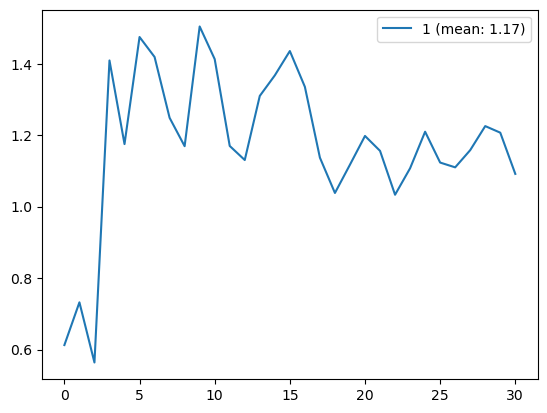

24/02/20 20:04:05 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 188390 ms exceeds timeout 120000 ms
24/02/20 20:04:05 WARN SparkContext: Killing executors is not supported by current scheduler.
24/02/20 20:04:13 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc

In [119]:
# signs = sign_extractor.retrieve_signs("BTCUSDT", f"2023-10-14", f"2023-10-14")
from statsmodels.tsa.tsatools import lagmat
from scipy import linalg
import statsmodels.api as sm
import multiprocessing
import time_test
importlib.reload(time_test)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ.pop("OMP_NUM_THREADS")



# start = time.time()
# nb_processes = 1
# process_args = [[] for _ in range(nb_processes)]
# direction = True
# for i in range(max_lag + 1):
#     # x_selection = x_pd.values[:, slice(i + 1)]
#     idx = i % len(process_args)

#     if (direction):
#         if (idx == len(process_args) - 1):
#             direction = False
#     else:
#         if (idx == len(process_args) - 1):
#             direction = True
#         idx = len(process_args) - 1 - idx
#     process_args[idx].append(i + 1)
#     # process_args[idx].append(np.array(x_selection))


# processes = []
# for i in range(nb_processes):
#     p = time_test.Process(x_pd, process_args[i], i + 1)
#     p.start()
#     processes.append(p)
#     # p.join()

# total = 0
# for p in processes:
#     p.join()
#     times = [p.q.get() for _ in range(len(p.all_idx))]
#     total += sum(times)
#     plt.plot(times, label=f"{p.id} (med: {round(np.mean(times), 2)})")
    
# plt.legend()
# plt.plot()

# end = time.time()
# print(end-start)
# print(total)


start = time.time()
from joblib import Parallel, delayed
nb_processes = 1
process_args = [[] for _ in range(nb_processes)]
direction = True
for i in range(max_lag + 1):
    x_selection = x_pd.values[:, slice(max_lag + 1)]
    idx = i % len(process_args)
    if (direction):
        if (idx == len(process_args) - 1):
            direction = False
    else:
        if (idx == len(process_args) - 1):
            direction = True
        idx = len(process_args) - 1 - idx

    process_args[idx].append(x_selection)


def compute_func_for_each_core(all_x):
    """ Work done by each core, specified by this function and the input """
    times = []
    for x in all_x:
        s = time.time()
        linalg.pinv(x)
        e = time.time()
        times.append(e - s)
        # print(f"Time: {round(e - s, 4)} s")
    return times

joblib_rets = Parallel(n_jobs=nb_processes, prefer='processes')(
    delayed(compute_func_for_each_core)(chunk) for chunk in process_args
)

total = 0
all_times = []
for i, times in enumerate(joblib_rets):
    all_times.extend(times)
    total += sum(times)
    plt.plot(times, label=f"{i + 1} (mean: {round(np.mean(times), 2)})")

end = time.time()

plt.legend()
plt.plot()
print(f"MEAN time: {round(np.mean(all_times), 2)} s")
print(f"Time: {end - start} (total: {total})")

In [16]:
import jax.numpy as jnp
from scipy import linalg
from statsmodels.tools.tools import pinv_extended
import os
from numba import jit
import numpy
import tensorflow as tf

N = 5
x = np.array([np.random.random(N) for _ in range(N)])

def v1(x):
    pseudo_inverse, rank = linalg.pinv(x, atol=0, rtol=0, return_rank=True)
    return pseudo_inverse

def v2(x):
    pseudo_inverse = np.linalg.pinv(x)
    return pseudo_inverse

@jit(nopython=True)
def v2_bis(x):
    pseudo_inverse = np.linalg.pinv(x)
    return pseudo_inverse

def v3(x):
    pseudo_inverse, singular_values = pinv_extended(x)
    return pseudo_inverse

# def v4(x):
#     inverse = linalg.inv(x)
#     return inverse

def v4(x):
    pseudo_inverse = tf.linalg.pinv(x, rcond=0)
    return pseudo_inverse

res_1 = v1(x)
res_2 = v2(x)
res_2_bis = v2_bis(x)
res_3 = v3(x)
res_4 = v4(x)

np.testing.assert_array_almost_equal(res_1, res_2, decimal=8)
np.testing.assert_array_almost_equal(res_1, res_2_bis, decimal=8)
np.testing.assert_array_almost_equal(res_1, res_3, decimal=8)
np.testing.assert_array_almost_equal(res_1, res_4, decimal=8)

Start v1
Start v2
Start v2_bis
Start v3
Start v4


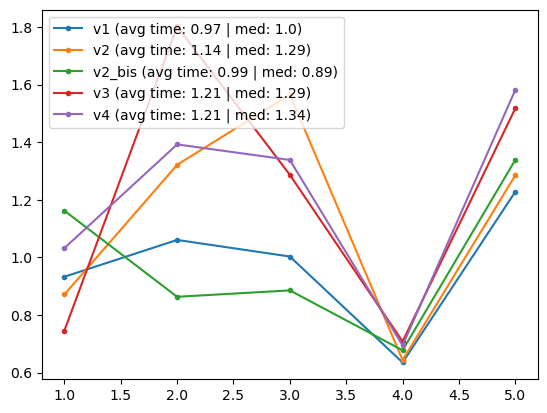

1. v1 => 0.97 s
2. v2_bis => 0.99 s
3. v2 => 1.14 s
4. v3 => 1.21 s
5. v4 => 1.21 s


In [14]:
from statsmodels.tsa.tsatools import lagmat
import statsmodels.api as sm
from modelisation.regression import linear_models
importlib.reload(linear_models)

def time_f(f, *arg):
    s = time.time()
    res = f(*arg)
    e = time.time()
    return res, e - s

def analyse_function_speed(function):
    times = []

    max_lag = 25
    for i in range(5, 10):
        date = f"2023-11-{i}"
        y = sign_extractor.retrieve_signs("APTUSDT", date, date)
        x, y = lagmat(y, max_lag, original="sep")
        x = sm.add_constant(x)
        y = y[max_lag:]
        x = x[max_lag:]
        x_pd = pd.DataFrame(x)

        current_time = 0
        for i in range(max_lag + 1):
            x_selection = x_pd.values[:, slice(i + 1)]
            ols_model = linear_models.OLS(y, x_selection)
            ols_model.df_model = x_selection.shape[1] - 1
            ols_model.k_constant = 1
            
            # res = ols_model.fit()
            # beta = res.beta
            _, t = time_f(function, x_selection)

            # Random beta
            # np.random.seed(i)
            # beta = np.random.random(size=i + 1)
    
            current_time += t
        times.append(current_time)

    return times

functions = [v1, v2, v2_bis, v3, v4]
labels = ["v1", "v2", "v2_bis", "v3", "v4"]
avgs = []
for function, label in zip(functions, labels):
    print(f"Start {label}")
    times = analyse_function_speed(function)
    avg_time = round(np.mean(times), 2)
    q50_time = round(np.median(times), 2)
    avgs.append((label, avg_time))
    plt.plot(list(range(1, len(times) + 1)), times, ".-", label=f"{label} (avg time: {avg_time} | med: {q50_time})")
plt.legend()
plt.show()
sorted_avgs = sorted(avgs, key=lambda x: x[1])
for i, el in enumerate(sorted_avgs):
    print(f"{i + 1}. {el[0]} => {el[1]} s")
# 1. v1 => 113.99 s
# 2. v3 => 118.48 s
# 3. v2 => 123.56 s

BTCUSDT 2023-10-10


    statsmodels => 3.73 s (1002272 signs, nb_lags: 38)
    opti        => 2.65 s (1002272 signs, nb_lags: 38)
    1 processes => 2.93 s (1002272 signs, nb_lags: 38)
    2 processes => 6.54 s (1002272 signs, nb_lags: 38)
    3 processes => 3.7 s (1002272 signs, nb_lags: 38)
    4 processes => 2.4 s (1002272 signs, nb_lags: 38)
    8 processes => 3.72 s (1002272 signs, nb_lags: 38)


BTCUSDT 2023-10-11


    statsmodels => 3.57 s (1336479 signs, nb_lags: 30)
    opti        => 2.68 s (1336479 signs, nb_lags: 30)
    1 processes => 2.54 s (1336479 signs, nb_lags: 30)
    2 processes => 3.22 s (1336479 signs, nb_lags: 30)
    3 processes => 2.57 s (1336479 signs, nb_lags: 30)
    4 processes => 1.98 s (1336479 signs, nb_lags: 30)
    8 processes => 3.41 s (1336479 signs, nb_lags: 30)


BTCUSDT 2023-10-12


    statsmodels => 3.03 s (1066082 signs, nb_lags: 38)
    opti        => 2.79 s (1066082 signs, nb_lags: 38)
    1 processes => 2.53 s (1066082 signs, nb_lags: 38)
    2 processes => 3.29 s (1066082 signs, nb_lags: 38)
    3 processes => 2.55 s (1066082 signs, nb_lags: 38)
    4 processes => 2.01 s (1066082 signs, nb_lags: 38)
    8 processes => 3.39 s (1066082 signs, nb_lags: 38)


BTCUSDT 2023-10-13


    statsmodels => 3.15 s (1035322 signs, nb_lags: 28)
    opti        => 2.96 s (1035322 signs, nb_lags: 28)
    1 processes => 2.69 s (1035322 signs, nb_lags: 28)
    2 processes => 3.37 s (1035322 signs, nb_lags: 28)
    3 processes => 2.41 s (1035322 signs, nb_lags: 28)
    4 processes => 2.04 s (1035322 signs, nb_lags: 28)
    8 processes => 3.37 s (1035322 signs, nb_lags: 28)




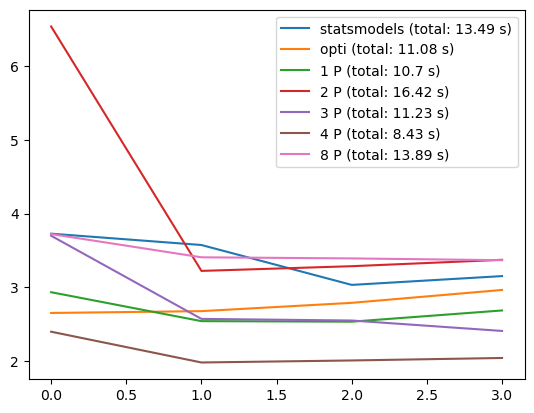

In [6]:
# Compare ar_select_order and ar_select_order_opti

from modelisation.time_series_models import autoregressive_model
importlib.reload(autoregressive_model)
import bis
importlib.reload(bis)

methods = ["statsmodels", "opti", "1 P", "2 P", "3 P", "4 P", "8 P"]
times_per_method = [[] for _ in range(len(methods))]
for i in range(10, 14):
    print(f"BTCUSDT 2023-10-{i}")
    signs = sign_extractor.retrieve_signs("BTCUSDT", f"2023-10-{i}", f"2023-10-{i}")
    # signs = sign_extractor.retrieve_signs("APTUSDT", f"2023-11-{i}", f"2023-11-{i}")
    ar_model = autoregressive_model.AutoregressiveModel(signs[:25000], nb_lags=None)

    s = time.time()
    nb_lags = ar_model.select_model_nb_lags("statsmodels")
    e = time.time()
    times_per_method[0].append(e - s)
    print(f"    statsmodels => {round(e - s, 2)} s ({len(signs)} signs, nb_lags: {nb_lags})")

    s = time.time()
    nb_lags = ar_model.select_model_nb_lags("opti")
    e = time.time()
    times_per_method[1].append(e - s)
    print(f"    opti        => {round(e - s, 2)} s ({len(signs)} signs, nb_lags: {nb_lags})")

    for i, nb_processes in enumerate([1, 2, 3, 4, 8]):
        s = time.time()
        nb_lags = ar_model.select_model_nb_lags("multi_processes", nb_processes=nb_processes)
        e = time.time()
        times_per_method[2 + i].append(e - s)
        print(f"    {nb_processes} processes => {round(e - s, 2)} s ({len(signs)} signs, nb_lags: {nb_lags})")
    print("\n")

for method, times in zip(methods, times_per_method):
    plt.plot(times, label=f"{method} (total: {round(sum(times), 2)} s)")
plt.legend()
plt.show()

In [18]:
def replace_negative_values_with(values, replacement_value):
    for i in range(len(values)):
        if (values[i] < 0):
            values[i] = replacement_value
    return values

def K(l, gamma=2.1):
    if (l == 0):
        return 1
    assert(l >= 1)
    return l ** (-1.82)


def plot_autocorrelation_training_and_simulated_signs(training_signs, simulated_signs, nb_lags=None, trained_until_lag=None, mode="full"):
    fig, axe = plt.subplots(1, 2, figsize=(18, 4))
    autocorrelation_training, autocorrelation_simulated = None, None
    if (nb_lags is None):
        autocorrelation_training = autocorrelation_calculator.autocorrelation_convolution(training_signs, mode=mode)
        autocorrelation_simulated = autocorrelation_calculator.autocorrelation_convolution(simulated_signs, mode=mode)
    else:
        autocorrelation_training = autocorrelation_calculator.autocorrelation_convolution_perso(training_signs, nb_lags)
        autocorrelation_simulated = autocorrelation_calculator.autocorrelation_convolution_perso(simulated_signs, nb_lags)

    pacf_training = pacf(training_signs, nb_lags)
    pacf_simulated = pacf(simulated_signs, nb_lags)

    axe[0].plot(autocorrelation_training, "black", linestyle="dashed", label=f"Training signs ({len(training_signs)}) autocorrelation function")
    axe[0].plot(autocorrelation_simulated, "blue", label=f"Simulated signs ({len(simulated_signs)}) autocorrelation function")
    # axe[0].plot(pacf_training, "grey", label=f"Training signs PACF ({len(simulated_signs)})")
    # axe[0].plot(pacf_simulated, "red", label=f"Simulated signs PACF ({len(simulated_signs)})")
    axe[0].set_title("Autocorrelation plot for training and simulated signs (linear scale)")
    axe[0].set_xlabel("Lag")
    axe[0].set_ylabel("Autocorrelation")
    axe[0].set_xlim(-5, nb_lags)
    axe[0].set_ylim(min(np.nanmin(autocorrelation_training), np.nanmin(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) - 0.1, max(np.nanmax(autocorrelation_training), np.nanmax(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) + 0.1)
    axe[0].grid()

    axe[1].plot(autocorrelation_training, "black", linestyle="dashed", label=f"Training signs ({len(training_signs)}) autocorrelation function")
    axe[1].plot(autocorrelation_simulated, "blue", label=f"Simulated signs ({len(simulated_signs)}) autocorrelation function")
    # axe[1].plot(pacf_training, "grey", label=f"Training signs PACF ({len(simulated_signs)})")
    # axe[1].plot(pacf_simulated, "red", label=f"Simulated signs PACF ({len(simulated_signs)})")
    axe[1].set_title("Autocorrelation plot for training and simulated signs (log scale)")
    axe[1].set_xlabel("Lag")
    axe[1].set_ylabel("Autocorrelation")
    axe[1].set_yscale("log")
    axe[1].set_xlim(-5, nb_lags)
    axe[1].set_ylim(max(0.001, min(np.nanmin(autocorrelation_training), np.nanmin(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) - 0.1), max(np.nanmax(autocorrelation_training), np.nanmax(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) + 0.1)
    axe[1].grid()

    if (trained_until_lag is not None):
        axe[0].axvline(x=trained_until_lag, color='grey', label="Lag until the model has been trained", linestyle='--')
        axe[1].axvline(x=trained_until_lag, color='grey', label="Lag until the model has been trained", linestyle='--')
    
    axe[0].legend()
    axe[1].legend()
  
    plt.show()

def plot_expected_value_details(values, title="Histogram", nb_bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].hist(values, bins=nb_bins, color='#0504aa', alpha=0.7, rwidth=0.85, density=True)
    axes[0].set_xlim(-1.2, 1.2)
    axes[0].set_xlabel("Expected value")
    axes[0].set_ylabel("Distribution")
    axes[0].set_title(title)

    axes[1].plot(values, color="orange")
    axes[1].set_ylim(-1.2, 1.2)
    axes[1].set_xlabel("Sign number")
    axes[1].set_ylabel("Expected value")
    axes[1].set_title("Expected value evolution")
    plt.show()
    
def f(l, gamma):
    if (l == 0):
        return 1
    return l ** ((gamma - 3) / 2)


<function autocorr_by_hand at 0x14ceb72e0>


In [3]:
signs = sign_extractor.retrieve_signs("APTUSDT", "2023-11-01", "2023-11-01")
# signs = pyspark_utils.get_column_from_pyspark_df(data.filter(F.col("date") == "20231101"), column_name="epsilon", sort_column=["time", "id"])
print(len(signs))
autocorrelation_true = metric_calculator.compute_autocorrelation(signs, 1000)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/04 19:03:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


98019


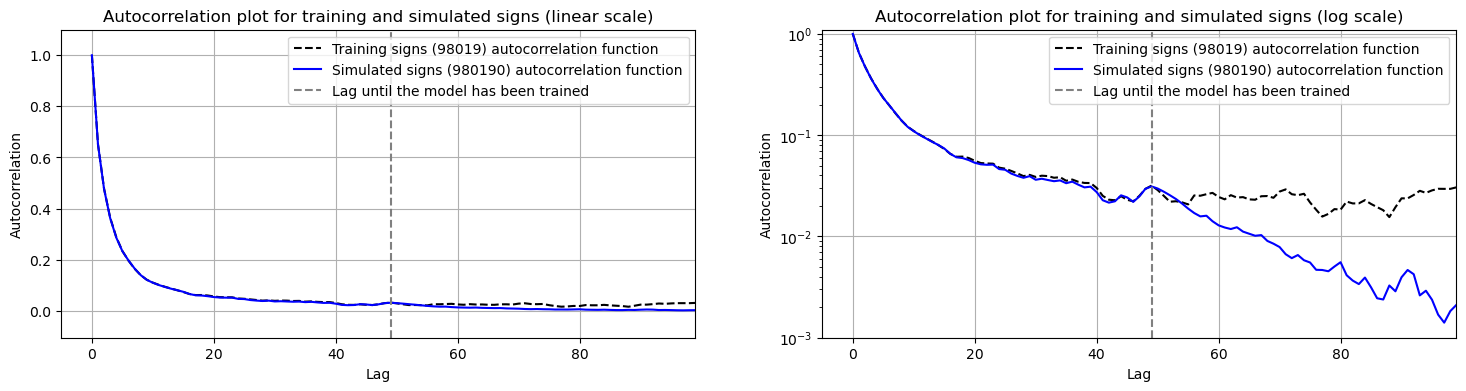

In [5]:
# V2
# Remove negative params? Normalize params? capp if proba_to_buy > 1 or < 0?
from modelisation.models import autoregressive_model
importlib.reload(autoregressive_model)
nb_signs_to_simulate = len(signs) * 10
simulated_signs, nb_lags = autoregressive_model.simulate_signs(signs, nb_lags=49, size=nb_signs_to_simulate)

plot_autocorrelation_training_and_simulated_signs(signs, simulated_signs, nb_lags=nb_lags+50, trained_until_lag=nb_lags)


In [ ]:

consecutives = []
current_sign = signs_filtered[0]
current_consecutive = 1
for sign in signs_filtered[1:]:
    if (sign == current_sign):
        current_consecutive += 1
    else:
        current_sign = sign
        if (current_consecutive > 0):
            consecutives.append(current_consecutive)
        current_consecutive = 1
    
print(consecutives)
# plt.hist(consecutives, bins=50, density=True)
# plt.plot(sorted(consecutives))
print(sum([1 for nb in consecutives if nb>5])/len(consecutives))

[1, 13, 1, 1, 1, 11, 1, 16, 21, 1, 4, 13, 2, 3, 1, 4, 4, 6, 6, 2, 1, 28, 19, 2, 1, 3, 12, 1, 18, 27, 4, 27, 21, 1, 9, 10, 19, 10, 6, 1, 1, 8, 9, 6, 2, 6, 11, 1, 1, 2, 15, 5, 6, 12, 3, 2, 15, 14, 9, 7, 5, 8, 8, 9, 9, 1, 5, 1, 3, 4, 11, 1, 1, 2, 2, 3, 30, 1, 3, 20, 1, 3, 4, 1, 4, 2, 5, 30, 7, 1, 1, 1, 1, 2, 1, 5, 2, 8, 5, 1, 10, 1, 1, 8, 10, 4, 9, 13, 25, 7, 60, 9, 4, 1, 2, 1, 4, 2, 4, 1, 13, 13, 4, 2, 53, 5, 4, 12, 9, 6, 13, 1, 5, 2, 4, 1, 2, 2, 14, 2, 2, 12, 19, 2, 7, 10, 5, 10, 1, 5, 8, 5, 11, 2, 4, 15, 3, 1, 8, 6, 32, 1, 16, 8, 1, 4, 1, 1, 2, 1, 1, 1, 10, 2, 5, 2, 1, 11, 12, 1, 5, 1, 4, 4, 5, 11, 16, 1, 15, 8, 2, 1, 18, 1, 19, 3, 6, 2, 2, 2, 2, 1, 1, 5, 11, 2, 1, 1, 5, 2, 13, 2, 15, 1, 14, 7, 2, 1, 28, 1, 4, 1, 9, 4, 6, 1, 1, 16, 2, 2, 1, 15, 3, 4, 3, 2, 16, 2, 8, 1, 1, 1, 9, 1, 5, 1, 3, 5, 18, 1, 2, 6, 2, 1, 1, 2, 1, 1, 5, 1, 4, 2, 23, 2, 3, 3, 8, 3, 2, 1, 44, 3, 7, 10, 2, 1, 21, 2, 55, 12, 1, 5, 4, 13, 1, 2, 1, 5, 19, 6, 11, 1, 1, 1, 10, 5, 3, 16, 1, 1, 39, 1, 1, 2, 6, 19, 2, 2, 1,

In [ ]:
times = []
lags = []

nb_loops = 10
print(len(signs_1))
importlib.reload(ar_model)
increment_of = len(signs_1) // nb_loops
i_start = 0
i_end = increment_of
current_loop = 1
while (current_loop <= nb_loops):
    signs_ = signs_1[i_start:i_end]
    # print(f"{current_loop} | {i_start} => {i_end} ({len(signs_)} signs)")

    s = time.time()
    mod = ar_model.ar_select_order(signs_, maxlag=100, ic="aic", trend="c")
    e = time.time()
    print(f"{current_loop} | {len(signs_)} signs => {len(mod.ar_lags)} lags | {round(e-s, 3)} s")

    times.append(e-s)
    lags.append(mod.ar_lags)

    if (current_loop < nb_loops - 1):
        i_end += increment_of
    else:
        i_end = len(signs_1)
    current_loop += 1



517837
1 | 0 => 51783 (51783 signs)
51783 signs => 36 lags | 53.437 s
2 | 0 => 103566 (103566 signs)
103566 signs => 57 lags | 100.703 s
3 | 0 => 155349 (155349 signs)
155349 signs => 57 lags | 128.303 s
4 | 0 => 207132 (207132 signs)
207132 signs => 57 lags | 400.092 s
5 | 0 => 258915 (258915 signs)
258915 signs => 58 lags | 208.593 s
6 | 0 => 310698 (310698 signs)
310698 signs => 60 lags | 306.537 s
7 | 0 => 362481 (362481 signs)
362481 signs => 98 lags | 346.206 s
8 | 0 => 414264 (414264 signs)
414264 signs => 98 lags | 342.764 s
9 | 0 => 466047 (466047 signs)
466047 signs => 98 lags | 2373.224 s
10 | 0 => 517837 (517837 signs)
517837 signs => 93 lags | 411.586 s


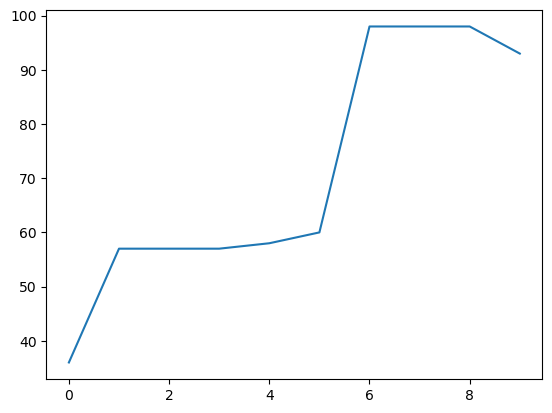

In [ ]:
# plt.plot(range(1, len(times) + 1), times)
nb_lags_ = [len(lag) for lag in lags]
nb_lags_
plt.plot(nb_lags_)

In [ ]:
# # nb_lags_candidates = [range(10, 201, 10)] + [range(300, 501, 100)]
# nb_lags_candidates = [nb_lags for nb_lags in range(10, 201, 10)] + [lags for lags in range(300, 1001, 100)]
# # nb_lags_candidates = [10, 20]
# print(len(nb_lags_candidates), nb_lags_candidates)
# nb_signs_to_simulate = len(signs_1)
# p = 1

# metric_results = pd.DataFrame(columns=["nb_lags","metric_buy_pct", "metric_std_buy_pct", "metric_mae_autocorrelation", "time_all_process", "time_model_fit", "time_sign_simulation"])
# for nb_lags in nb_lags_candidates:
#     print(f"Current nb_lags: {nb_lags}")
#     metric_buy_pct, metric_std_buy_pct, metric_mae_autocorrelation, time_all_process, time_model_fit, time_sign_simulation = generate_n_future_signs_V2(autocorrelation_true, signs_1, nb_signs_to_simulate, nb_lags, p, include_cst_param=True)
#     metric_results.loc[len(metric_results.index)] = [nb_lags, metric_buy_pct, metric_std_buy_pct, metric_mae_autocorrelation, time_all_process, time_model_fit, time_sign_simulation]

# metric_results["nb_lags"] = metric_results["nb_lags"].astype("int")
# display(metric_results)
# metric_results.to_excel("/Users/martingangand/Documents/trade_flow_modelling/metric_results/metric_results_different_nb_lags.xlsx")

In [ ]:
importlib.reload(sign_simulator)
sign_simulator.select_appropriate_nb_lags(signs_filtered)

49

In [ ]:
int(np.ceil(12.0 * np.power(1000000 / 100.0, 1 / 4.0)))

120

In [ ]:
import statsmodels.tsa.stattools as stattools
importlib.reload(stattools)
from typing import Literal

X = signs_filtered



print(is_time_series_stationary(X, verbose=True))

Test Statistic: -31.816876336055586
p-value: 0.0
#Lags Used: 72
Number of Observations Used: 125546
Critical Value (1%%): -3.4304020879495085
Critical Value (5%%): -2.861563022109245
Critical Value (10%%): -2.5667822538541594
True


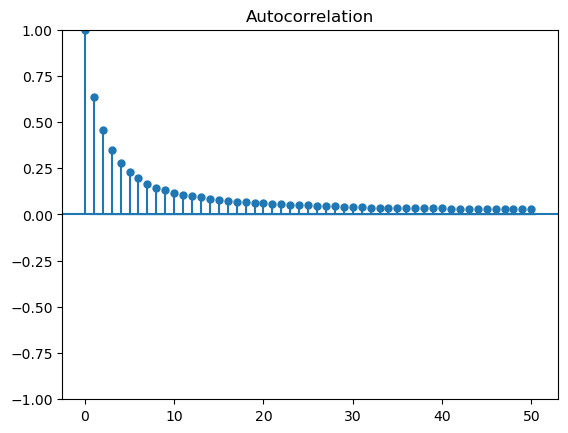

In [42]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# pacf = plot_pacf(signs_test, lags=50)
acf = plot_acf(signs, lags=50)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(signs_test, lags=125).fit()
#
# Print Summary
#
# print(ar_model.summary())
coeffs = ar_model.params[1:]
print(len(coeffs), sum(coeffs))
print(coeffs[:10])
# plt.plot(coeffs)


125 0.9441001437863615
[0.31204807 0.14108772 0.08984722 0.06251513 0.04792222 0.03515184
 0.03077804 0.02621214 0.01825998 0.02001144]


In [ ]:
print(sum(ar_model.bse))

0.21141314609300924


0.8705
-0.7815999999999999
========================== START (, 500000 signs) ==========================
Buy: 236878 (47.376%) | Sell 263122 (52.624%)
Portions of 50000 => [52.18% (50000) | 49.06% (50000) | 47.52% (50000) | 48.35% (50000) | 47.58% (50000) | 37.95% (50000) | 51.63% (50000) | 42.36% (50000) | 46.05% (50000) | 51.07% (50000)]
========================== END (, 500000 signs) ==========================

-0.05254363430816333


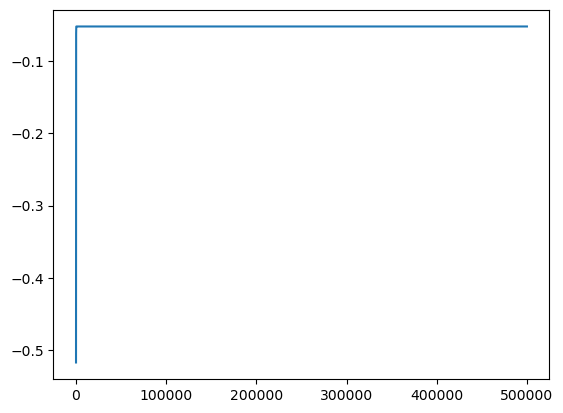

In [ ]:
a = [0.2690, 0.1425, 0.0964, 0.0758, 0.0553, 0.0512, 0.0571, 0.0334, 0.0394, 0.0504]
b = [1.0363, 1.0402,1.0402, 0.4044,0.4044, -0.4457, -0.4457, -1.1777 , -1.1777 , -1.4603]
print(sum(a))
print(sum(b))
pred = ar_model.predict(start=len(signs_test), end=len(signs_test) * 2, dynamic=False)
print_signs_info(signs_test, "")
plt.plot(pred)
print(pred[1000])

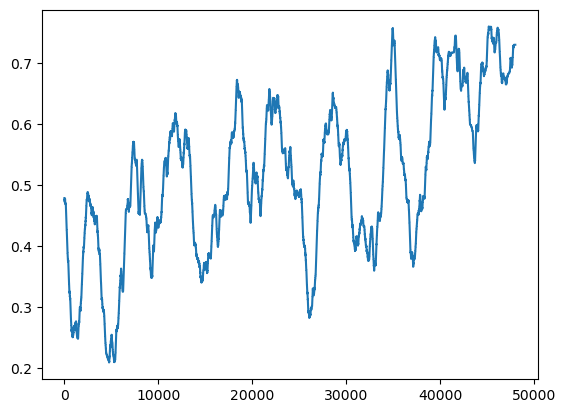

In [ ]:
values = []
def buy_percentage(signs):
    return np.sum([1 for sign in signs if sign == 1]) / len(signs)

l = 2000
for i in range(l, len(signs_test)):
    values.append(buy_percentage(signs_test[i-l:i]))
    # values.append(np.mean(signs_test[i-l:i]))
plt.plot(values)

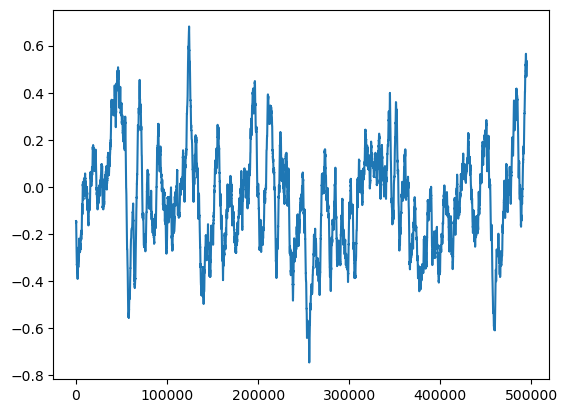

In [ ]:
signs_test = signs[:500000]
values = []
l = 5000
for i in range(l, len(signs_test)):
    values.append(np.mean(signs_test[i-l:i]))
plt.plot(values)

In [ ]:
def autocorrelation_statistical(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])
print(autocorrelation_statistical(signs_test))

[1.         0.59084605 0.53501419 0.46604099 0.49977718 0.48305675
 0.50498983 0.45317801 0.41039251 0.40268901 0.38569504 0.40761022
 0.35510937 0.35838048 0.34119561 0.35381085 0.34125136 0.33510839
 0.29424418 0.30212177]


In [32]:
import statsmodels.tsa.api as smt
smt.acovf(signs)[:10]

array([0.99999913, 0.63316425, 0.45564087, 0.34743652, 0.27736922,
       0.22877432, 0.19516673, 0.16747309, 0.14512949, 0.12975537])

276634
The Autocorrelation plot for the data is:


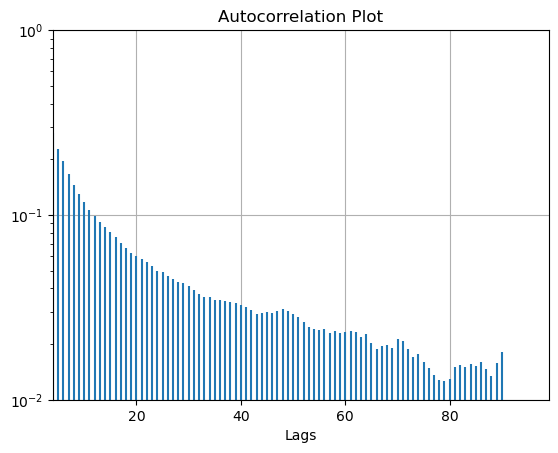

In [43]:
# Adding plot title.
plt.title("Autocorrelation Plot") 
print(len(signs))
# Providing x-axis name.
plt.xlabel("Lags") 
s = [float(i) for i in signs]
# Plotting the Autocorrelation plot.
plt.acorr(s, maxlags = 90) 

# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.yscale("log")
plt.grid(True)
plt.xlim(left=4)
plt.ylim(0.01, 1)
plt.show()

In [ ]:
def order_sign_imbalance(signs):
    return np.sum(signs) / len(signs)